<a href="https://colab.research.google.com/github/Kussil/Financial_Sentiment_LLM/blob/main/04_Stock_Modeling/Aggregated_Stock_Data/Llama_Prompt/Stock_Modeling_Llama_prompt_All_WR_RF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stock Modeling using Gemini Sentiments with Prompt 2: All



In [1]:
#install dependencies
!pip install -q ipympl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 516.3/516.3 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 16.2 MB/s eta 0:00:00


In [2]:
# import libraries
import os
from google.colab import userdata
from google.colab import output
import pandas as pd
import yfinance as yf
import textwrap
import matplotlib
import matplotlib.pyplot as plt
from datetime import datetime
import pytz
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import mean_squared_error, accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
output.enable_custom_widget_manager()

In [3]:
#Delete repo clone if needed
!rm -rf /content/CVX_Rice_project/

In [4]:
# Import github token with google secrets thingy and clone git repository
GITHUB_TOKEN = userdata.get('github')
os.environ['GITHUB_TOKEN'] = GITHUB_TOKEN
!git clone https://{GITHUB_TOKEN}@github.com/Kussil/Financial_Sentiment_LLM.git

Cloning into 'Financial_Sentiment_LLM'...
remote: Enumerating objects: 3141, done.
remote: Counting objects: 100% (707/707), done.
remote: Compressing objects: 100% (367/367), done.
remote: Total 3141 (delta 415), reused 585 (delta 336), pack-reused 2434
Receiving objects: 100% (3141/3141), 526.93 MiB | 11.99 MiB/s, done.
Resolving deltas: 100% (2047/2047), done.
Updating files: 100% (1225/1225), done.


In [5]:
# Read in outputs from Gemini Sentiment Analysis
Llama_sentiment = pd.read_csv('/content/Financial_Sentiment_LLM/03_Sentiment_Analysis/LLama/Llama_data_for_stock_modeling.csv')
Llama_sentiment = Llama_sentiment.fillna('')
Llama_sentiment

,Source,Unique_ID,Ticker,Date,URL,Finance,Production,Reserves/M&A,Regulatory,Green Energy,OG Price
0,Investment Research,IR-1,MRO,2024-05-16,,Neutral,Positive,Neutral,Neutral,Neutral,Neutral
1,Investment Research,IR-2,EOG,2024-05-14,,Positive,Neutral,Neutral,Neutral,Negative,Neutral
2,Investment Research,IR-3,EOG,2024-05-11,,Positive,Neutral,Positive,Negative,Neutral,Positive
3,Investment Research,IR-4,DVN,2024-05-11,,Neutral,Negative,Neutral,Neutral,Negative,Negative
4,Investment Research,IR-5,COP,2024-05-07,,Neutral,Positive,Neutral,Negative,Neutral,Positive
...,...,...,...,...,...,...,...,...,...,...,...
10120,Earnings Call Q&A,EQ-338,XOM,2021-02-02,,Neutral,Positive,Neutral,Neutral,Positive,Neutral
10121,Earnings Call Q&A,EQ-339,COP,2021-02-02,,Negative,Negative,Negative,Negative,Negative,Negative
10122,Earnings Call Q&A,EQ-340,EOG,2019-05-03,,Neutral,Positive,Positive,Neutral,Neutral,Neutral
10123,Earnings Call Q&A,EQ-341,SHEL,2019-05-02,,Negative,Negative,Negative,Negative,Negative,Negative


In [6]:
source_values = Llama_sentiment["Source"].unique()
source_values


array(['Investment Research', 'ProQuest', 'SEC Filings',
       'Earnings Call Presentations', 'Earnings Call Q&A'], dtype=object)

In [7]:
# Define a list of date formats
date_formats = [
    '%d/%m/%Y',  # 01/01/2021
    '%m/%d/%Y',  # 5/16/2024
    '%Y-%m-%d',  # 2021-02-28
    '%B %d, %Y',  # March 15, 2021
    '%b-%d-%Y',  # Apr-30-2019
    '%Y.%m.%d',  # 2021.04.10
    '%m-%d-%Y',  # 04-10-2021
    '%d-%b-%y',  # 17-Aug-22
    '%b-%y'  # Sep-19
]

# Function to parse dates with multiple formats
def parse_date(date_str):
    for fmt in date_formats:
        try:
            # Handle special case where only month and year are given
            if fmt == '%b-%y':
                parsed_date = datetime.strptime(date_str, fmt)
                # Default to the first day of the month
                return parsed_date.replace(day=1)
            return datetime.strptime(date_str, fmt)
        except ValueError:
            continue
    raise ValueError(f"Date format not recognized: {date_str}")

# Apply the function to the 'Date' column
Llama_sentiment['Date'] = Llama_sentiment['Date'].apply(parse_date)

# Format the dates in a specific string format
Llama_sentiment['Date'] = Llama_sentiment['Date'].dt.strftime('%Y-%m-%d')

# Modifying the original dataframe to only include rows where the source is "Earnings Call Presentations" or "Earnings Call Q&A"
#gemini_prompt2_sentiment = gemini_prompt2_sentiment[gemini_prompt2_sentiment["Source"] == "SEC Filings"]

# Display the DataFrame
Llama_sentiment

,Source,Unique_ID,Ticker,Date,URL,Finance,Production,Reserves/M&A,Regulatory,Green Energy,OG Price
0,Investment Research,IR-1,MRO,2024-05-16,,Neutral,Positive,Neutral,Neutral,Neutral,Neutral
1,Investment Research,IR-2,EOG,2024-05-14,,Positive,Neutral,Neutral,Neutral,Negative,Neutral
2,Investment Research,IR-3,EOG,2024-05-11,,Positive,Neutral,Positive,Negative,Neutral,Positive
3,Investment Research,IR-4,DVN,2024-05-11,,Neutral,Negative,Neutral,Neutral,Negative,Negative
4,Investment Research,IR-5,COP,2024-05-07,,Neutral,Positive,Neutral,Negative,Neutral,Positive
...,...,...,...,...,...,...,...,...,...,...,...
10120,Earnings Call Q&A,EQ-338,XOM,2021-02-02,,Neutral,Positive,Neutral,Neutral,Positive,Neutral
10121,Earnings Call Q&A,EQ-339,COP,2021-02-02,,Negative,Negative,Negative,Negative,Negative,Negative
10122,Earnings Call Q&A,EQ-340,EOG,2019-05-03,,Neutral,Positive,Positive,Neutral,Neutral,Neutral
10123,Earnings Call Q&A,EQ-341,SHEL,2019-05-02,,Negative,Negative,Negative,Negative,Negative,Negative


In [8]:
# Renaming the columns to simplify sentiment categories
Llama_sentiment.rename(columns={
    'Reserves / Exploration / Acquisitions / Mergers / Divestments': 'Reserves/M&A',
    'Environment / Regulatory / Geopolitics': 'Regulatory',
    'Alternative Energy / Lower Carbon': 'Green Energy',
    'Oil Price / Natural Gas Price / Gasoline Price': 'OG Price'
}, inplace=True)

Llama_sentiment

,Source,Unique_ID,Ticker,Date,URL,Finance,Production,Reserves/M&A,Regulatory,Green Energy,OG Price
0,Investment Research,IR-1,MRO,2024-05-16,,Neutral,Positive,Neutral,Neutral,Neutral,Neutral
1,Investment Research,IR-2,EOG,2024-05-14,,Positive,Neutral,Neutral,Neutral,Negative,Neutral
2,Investment Research,IR-3,EOG,2024-05-11,,Positive,Neutral,Positive,Negative,Neutral,Positive
3,Investment Research,IR-4,DVN,2024-05-11,,Neutral,Negative,Neutral,Neutral,Negative,Negative
4,Investment Research,IR-5,COP,2024-05-07,,Neutral,Positive,Neutral,Negative,Neutral,Positive
...,...,...,...,...,...,...,...,...,...,...,...
10120,Earnings Call Q&A,EQ-338,XOM,2021-02-02,,Neutral,Positive,Neutral,Neutral,Positive,Neutral
10121,Earnings Call Q&A,EQ-339,COP,2021-02-02,,Negative,Negative,Negative,Negative,Negative,Negative
10122,Earnings Call Q&A,EQ-340,EOG,2019-05-03,,Neutral,Positive,Positive,Neutral,Neutral,Neutral
10123,Earnings Call Q&A,EQ-341,SHEL,2019-05-02,,Negative,Negative,Negative,Negative,Negative,Negative


In [9]:
#Create Positive and Negative Ratios for each row

# Columns to consider for calculating ratios
columns_to_check = ['Finance', 'Production', 'Reserves/M&A', 'Regulatory', 'Green Energy', 'OG Price']

# Function to calculate positive and negative ratios
def calculate_ratios(row):
    positive_count = (row[columns_to_check] == 'Positive').sum()
    negative_count = (row[columns_to_check] == 'Negative').sum()
    neutral_count = (row[columns_to_check] == 'Neutral').sum()
    total_count = len(columns_to_check)
    pos_ratio = positive_count / total_count
    neg_ratio = negative_count / total_count
    neu_ratio = neutral_count / total_count
    return pd.Series([pos_ratio, neg_ratio, neu_ratio], index=['Pos_Ratio', 'Neg_Ratio', 'Neu_Ratio'])

# Apply the function to each row
Llama_sentiment[['Pos_Ratio', 'Neg_Ratio', 'Neu_Ratio']] = Llama_sentiment.apply(calculate_ratios, axis=1)

# Replace senitment category values with binary equivalents
binary_mapping = {'Positive': 1, 'Negative': -1, 'Neutral': 0}
Llama_sentiment[columns_to_check] = Llama_sentiment[columns_to_check].replace(binary_mapping)

Llama_sentiment

,Source,Unique_ID,Ticker,Date,URL,Finance,Production,Reserves/M&A,Regulatory,Green Energy,OG Price,Pos_Ratio,Neg_Ratio,Neu_Ratio
0,Investment Research,IR-1,MRO,2024-05-16,,0,1,0,0,0,0,0.166667,0.000000,0.833333
1,Investment Research,IR-2,EOG,2024-05-14,,1,0,0,0,-1,0,0.166667,0.166667,0.666667
2,Investment Research,IR-3,EOG,2024-05-11,,1,0,1,-1,0,1,0.500000,0.166667,0.333333
3,Investment Research,IR-4,DVN,2024-05-11,,0,-1,0,0,-1,-1,0.000000,0.500000,0.500000
4,Investment Research,IR-5,COP,2024-05-07,,0,1,0,-1,0,1,0.333333,0.166667,0.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10120,Earnings Call Q&A,EQ-338,XOM,2021-02-02,,0,1,0,0,1,0,0.333333,0.000000,0.666667
10121,Earnings Call Q&A,EQ-339,COP,2021-02-02,,-1,-1,-1,-1,-1,-1,0.000000,1.000000,0.000000
10122,Earnings Call Q&A,EQ-340,EOG,2019-05-03,,0,1,1,0,0,0,0.333333,0.000000,0.666667
10123,Earnings Call Q&A,EQ-341,SHEL,2019-05-02,,-1,-1,-1,-1,-1,-1,0.000000,1.000000,0.000000


In [10]:
#Identify minimum article date for stock price download
min_date = Llama_sentiment['Date'].min()
min_date

'2019-01-07'

In [11]:
ticker_list = Llama_sentiment['Ticker'].unique().tolist()
ticker_list

['MRO',
 'EOG',
 'DVN',
 'COP',
 'PXD',
 'PDCE',
 'CXO',
 'CVX',
 'MPC',
 'HES',
 'PSX',
 'XOM',
 'SHEL',
 'BP',
 'OXY',
 'VLO',
 'TTE',
 'EQNR']

In [12]:
# Pull YahooFinance stock data to get Returns (ret)
all_data = {}

for ticker in ticker_list:
    try:
        # Get the last date for the current ticker from gemini_prompt1_sentiment
        last_date = Llama_sentiment[Llama_sentiment['Ticker'] == ticker]['Date'].max()
        if pd.isna(last_date):
            print(f"No data available for {ticker} in gemini_prompt1_sentiment.")
            continue

        # Ensure the date is in the correct format
        last_date = pd.to_datetime(last_date).strftime('%Y-%m-%d')
        print(f"Downloading data for {ticker} from {min_date} to {last_date}")

        # Download stock data
        data = yf.download(ticker, start=min_date, end=last_date)["Adj Close"]

        if data.empty:
            print(f"No data retrieved for {ticker}")
        else:
            all_data[ticker] = data

    except Exception as e:
        print(f"Error downloading data for {ticker}: {e}")

# Combine all data into a single DataFrame
if all_data:
    price_df = pd.DataFrame(all_data)

    # Calculate daily returns
    ret_df = price_df.pct_change().dropna()
    ret_df.name = "ret"

    # Calculate weekly returns (5 trading days)
    weekly_ret_df = price_df.pct_change(periods=5).dropna()
    weekly_ret_df.name = "weekly_ret"

    # Optionally, you can join daily and weekly returns into a single DataFrame
    combined_ret_df = pd.concat([ret_df, weekly_ret_df], axis=1, keys=["daily_ret", "weekly_ret"]).dropna()

    print(combined_ret_df.describe())

else:
    print("No data available.")

[*********************100%%**********************]  1 of 1 completed


[*********************100%%**********************]  1 of 1 completed


[*********************100%%**********************]  1 of 1 completed


[*********************100%%**********************]  1 of 1 completed


[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['PXD']: YFTzMissingError('$%ticker%: possibly delisted; No timezone found')


No data retrieved for PXD


[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['PDCE']: YFInvalidPeriodError("%ticker%: Period 'max' is invalid, must be one of ['1d', '5d']")


No data retrieved for PDCE


[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['CXO']: YFTzMissingError('$%ticker%: possibly delisted; No timezone found')


No data retrieved for CXO


[*********************100%%**********************]  1 of 1 completed


[*********************100%%**********************]  1 of 1 completed


[*********************100%%**********************]  1 of 1 completed


[*********************100%%**********************]  1 of 1 completed


[*********************100%%**********************]  1 of 1 completed


[*********************100%%**********************]  1 of 1 completed


[*********************100%%**********************]  1 of 1 completed


[*********************100%%**********************]  1 of 1 completed


[*********************100%%**********************]  1 of 1 completed


[*********************100%%**********************]  1 of 1 completed


[*********************100%%**********************]  1 of 1 completed

         daily_ret                                                      \
               MRO          EOG          DVN          COP          CVX   
count  1350.000000  1350.000000  1350.000000  1350.000000  1350.000000   
mean      0.001093     0.000801     0.001363     0.000961     0.000697   
std       0.036166     0.029507     0.036498     0.027327     0.021741   
min      -0.468521    -0.320073    -0.373972    -0.248401    -0.221248   
25%      -0.017094    -0.014106    -0.016769    -0.011746    -0.008432   
50%       0.000642    -0.000133     0.000440     0.000000     0.000733   
75%       0.017345     0.014872     0.017776     0.014061     0.009541   
max       0.232445     0.165702     0.210721     0.252138     0.227407   

                                                                        ...  \
               MPC          HES          PSX          XOM         SHEL  ...   
count  1350.000000  1350.000000  1350.000000  1350.000000  1350.000000  ...   
mean      0.001305    

In [14]:
ret_df.describe()

,MRO,EOG,DVN,COP,CVX,MPC,HES,PSX,XOM,SHEL,BP,OXY,VLO,TTE,EQNR
count,1354.000000,1354.000000,1354.000000,1354.000000,1354.000000,1354.000000,1354.000000,1354.000000,1354.000000,1354.000000,1354.000000,1354.000000,1354.000000,1354.000000,1354.000000
mean,0.001113,0.000818,0.001389,0.000992,0.000696,0.001332,0.001405,0.000844,0.000791,0.000575,0.000433,0.000883,0.001177,0.000674,0.000711
std,0.036132,0.029489,0.036448,0.027316,0.021714,0.029227,0.030540,0.025946,0.020974,0.022666,0.022967,0.038527,0.029712,0.021057,0.023944
min,-0.468521,-0.320073,-0.373972,-0.248401,-0.221248,-0.270089,-0.336686,-0.158658,-0.122248,-0.171722,-0.191040,-0.520138,-0.192209,-0.178208,-0.210562
25%,-0.017074,-0.014106,-0.016666,-0.011746,-0.008418,-0.012158,-0.014324,-0.010620,-0.010156,-0.009652,-0.010054,-0.014985,-0.012675,-0.009622,-0.011592
50%,0.000642,-0.000133,0.000569,0.000000,0.000733,0.001711,0.001130,0.000730,0.000387,0.000400,0.000000,0.000000,0.000464,0.001223,0.000000
75%,0.017404,0.014872,0.017769,0.014071,0.009541,0.015112,0.015564,0.013697,0.011249,0.010831,0.009810,0.015092,0.015847,0.010395,0.013550
max,0.232445,0.165702,0.210721,0.252138,0.227407,0.206286,0.203153,0.221723,0.126868,0.196794,0.216053,0.336977,0.312025,0.152756,0.133042


In [15]:
combined_ret_df.describe()

daily_ret                                                      \
               MRO          EOG          DVN          COP          CVX   
count  1350.000000  1350.000000  1350.000000  1350.000000  1350.000000   
mean      0.001093     0.000801     0.001363     0.000961     0.000697   
std       0.036166     0.029507     0.036498     0.027327     0.021741   
min      -0.468521    -0.320073    -0.373972    -0.248401    -0.221248   
25%      -0.017094    -0.014106    -0.016769    -0.011746    -0.008432   
50%       0.000642    -0.000133     0.000440     0.000000     0.000733   
75%       0.017345     0.014872     0.017776     0.014061     0.009541   
max       0.232445     0.165702     0.210721     0.252138     0.227407   

                                                                        ...  \
               MPC          HES          PSX          XOM         SHEL  ...   
count  1350.000000  1350.000000  1350.000000  1350.000000  1350.000000  ...   
mean      0.001305     0.001357     0.000836     0.000791     0.000578  ...   
std       0.029259     0.030553     0.025982     0.021003     0.022695  ...   
min      -0.270089    -0.336686    -0.158658    -0.122248    -0.171722  ...   
25%      -0.012223    -0.014408    -0.010669    -0.010177    -0.009652  ...   
50%       0.001694     0.001113     0.000730     0.000387     0.000400  ...   
75%       0.015044     0.015422     0.013747     0.011269     0.010831  ...   
max       0.206286     0.203153     0.221723     0.126868     0.196794  ...   

        weekly_ret                                                      \
               MPC          HES          PSX          XOM         SHEL   
count  1350.000000  1350.000000  1350.000000  1350.000000  1350.000000   
mean      0.006748     0.006659     0.004154     0.003878     0.002933   
std       0.066158     0.064264     0.056941     0.045278     0.052122   
min      -0.465880    -0.423326    -0.355377    -0.258032    -0.373152   
25%      -0.024009    -0.028378    -0.027170    -0.021443    -0.019429   
50%       0.008231     0.005842     0.002375     0.003324     0.001976   
75%       0.040411     0.042858     0.035402     0.027609     0.026110   
max       0.463899     0.280578     0.286767     0.192369     0.588344   

                                                                        
                BP          OXY          VLO          TTE         EQNR  
count  1350.000000  1350.000000  1350.000000  1350.000000  1350.000000  
mean      0.002249     0.004345     0.005788     0.003444     0.003438  
std       0.053176     0.086013     0.064586     0.049308     0.051457  
min      -0.346715    -0.630805    -0.356486    -0.331419    -0.376046  
25%      -0.021886    -0.033935    -0.028369    -0.019463    -0.025842  
50%       0.000753    -0.000329     0.006479     0.002760     0.003526  
75%       0.026214     0.035398     0.041190     0.025063     0.031343  
max       0.507759     0.766835     0.446659     0.459217     0.320136  

[8 rows x 30 columns]

In [16]:
combined_ret_df

daily_ret                                                    \
                 MRO       EOG       DVN       COP       CVX       MPC   
Date                                                                     
2019-01-14 -0.017381  0.016930 -0.007208 -0.011749 -0.007286  0.000154   
2019-01-15  0.000000  0.000812  0.008789  0.006402  0.003580 -0.008477   
2019-01-16 -0.018320  0.003050 -0.019318 -0.005603 -0.006422  0.000155   
2019-01-17  0.016088  0.003851  0.019312  0.021322  0.005027  0.022537   
2019-01-18  0.019633  0.020192  0.028420  0.012526  0.021526  0.004560   
...              ...       ...       ...       ...       ...       ...   
2024-05-17  0.003062  0.015791  0.000000  0.000000  0.000000  0.000000   
2024-05-20  0.009538 -0.000616  0.000000  0.000000  0.000000  0.000000   
2024-05-21 -0.006425 -0.007393  0.000000  0.000000  0.000000  0.000000   
2024-05-22 -0.015595 -0.022110  0.000000  0.000000  0.000000  0.000000   
2024-05-23  0.000000 -0.016025  0.000000  0.000000  0.000000  0.000000   

                                                    ... weekly_ret            \
                 HES       PSX       XOM      SHEL  ...        MPC       HES   
Date                                                ...                        
2019-01-14 -0.008972  0.001511 -0.001255 -0.002147  ...   0.042082  0.061195   
2019-01-15  0.019878 -0.004094  0.000559  0.000165  ...   0.023223  0.068895   
2019-01-16 -0.010421  0.005841 -0.000419 -0.006455  ...   0.001868  0.022329   
2019-01-17  0.010921  0.004624  0.006840  0.002499  ...   0.033946 -0.002117   
2019-01-18  0.018711  0.020124  0.011923  0.014789  ...   0.018807  0.030037   
...              ...       ...       ...       ...  ...        ...       ...   
2024-05-17  0.011516  0.000000  0.000000  0.000000  ...  -0.028124 -0.014277   
2024-05-20 -0.014420  0.000000  0.000000  0.000000  ...  -0.018835 -0.023683   
2024-05-21  0.000000  0.000000  0.000000  0.000000  ...   0.000000 -0.016721   
2024-05-22  0.000000  0.000000  0.000000  0.000000  ...   0.000000 -0.005679   
2024-05-23  0.000000  0.000000  0.000000  0.000000  ...   0.000000 -0.003071   

                                                                        \
                 PSX       XOM      SHEL        BP       OXY       VLO   
Date                                                                     
2019-01-14  0.014868  0.001538 -0.003628  0.006474  0.017059  0.024128   
2019-01-15  0.011598 -0.005136  0.002655  0.005246  0.008155  0.018227   
2019-01-16  0.010871 -0.010771 -0.015256 -0.005947 -0.009729  0.022124   
2019-01-17  0.005165  0.001110 -0.017309 -0.014005 -0.005439  0.039654   
2019-01-18  0.028158  0.017708  0.008754  0.012923  0.012232  0.052504   
...              ...       ...       ...       ...       ...       ...   
2024-05-17  0.001717  0.007353  0.000000  0.000000  0.000000  0.063601   
2024-05-20  0.005307  0.007780  0.000000  0.000000  0.000000  0.064965   
2024-05-21  0.006904  0.001700  0.000000  0.000000  0.000000  0.064965   
2024-05-22 -0.002462 -0.005988  0.000000  0.000000  0.000000  0.052945   
2024-05-23  0.000000  0.000000  0.000000  0.000000  0.000000  0.047697   

                                
                 TTE      EQNR  
Date                            
2019-01-14 -0.001104 -0.008897  
2019-01-15 -0.007012 -0.006643  
2019-01-16 -0.032142 -0.029668  
2019-01-17 -0.021835 -0.019685  
2019-01-18  0.012433  0.006634  
...              ...       ...  
2024-05-17  0.000000  0.008456  
2024-05-20  0.000000  0.003531  
2024-05-21  0.000000  0.001784  
2024-05-22  0.000000  0.000000  
2024-05-23  0.000000  0.000000  

[1350 rows x 30 columns]

In [19]:

# List of columns to convert
numeric_columns = ['Finance', 'Production', 'Reserves/M&A', 'Regulatory', 'Green Energy', 'OG Price']

# Convert columns to numeric
df_sentiment[numeric_columns] = df_sentiment[numeric_columns].apply(pd.to_numeric, errors='coerce')

# Check for any remaining NaNs and decide how to handle them
print(df_sentiment[numeric_columns].isna().sum())
# Option 1: Fill NaNs with a specific value, e.g., 0
df_sentiment[numeric_columns] = df_sentiment[numeric_columns].fillna(0)

# Option 2: Drop rows with NaN values
# df_sentiment = df_sentiment.dropna(subset=numeric_columns)

Finance         53
Production      53
Reserves/M&A    55
Regulatory      54
Green Energy    55
OG Price        55
dtype: int64


In [20]:
# add overall article sentiment
df_sentiment = Llama_sentiment

# Function to calculate positive and negative ratios
def calculate_ratios2(row):
    positive_count = (row[columns_to_check] == 1).sum()
    negative_count = (row[columns_to_check] == -1).sum()
    neutral_count = (row[columns_to_check] == 0).sum()
    total_count = len(columns_to_check)
    pos_ratio = positive_count / total_count
    neg_ratio = negative_count / total_count
    neu_ratio = neutral_count / total_count
    return pd.Series([pos_ratio, neg_ratio, neu_ratio], index=['Pos_Ratio2', 'Neg_Ratio2', 'Neu_Ratio2'])

# Apply the function to each row
df_sentiment[['Pos_Ratio2', 'Neg_Ratio2', 'Neu_Ratio2']] = df_sentiment.apply(calculate_ratios2, axis=1)

# Aggregate by ticker and date
df_grouped = df_sentiment.groupby(['Ticker', 'Date']).agg(
    article_count=('Unique_ID', 'size'),
    Finance=('Finance', 'sum'),
    Production=('Production', 'sum'),
    Reserves_MA=('Reserves/M&A', 'sum'),
    Regulatory=('Regulatory', 'sum'),
    Green_Energy=('Green Energy', 'sum'),
    OG_Price=('OG Price', 'sum'),
    Neu_ratio_avg=('Neu_Ratio2', 'mean'),
    Pos_ratio_avg=('Pos_Ratio2', 'mean'),
    Neg_ratio_avg=('Neg_Ratio2', 'mean')
).reset_index()

# Adding Date String column
df_grouped['Date String'] = df_grouped['Date'].astype(str)

# Reshape daily returns
ret_stack_daily = ret_df.stack().reset_index()
ret_stack_daily.columns = ['Date', 'Ticker', 'Daily_Returns']
ret_stack_daily['Date'] = pd.to_datetime(ret_stack_daily['Date'], format='mixed')
ret_stack_daily['Date'] = pd.to_datetime(ret_stack_daily['Date']).dt.date
ret_stack_daily['Date String'] = ret_stack_daily['Date'].astype(str)
ret_stack_daily.drop(columns=['Date'], inplace=True)

# Reshape weekly returns
weekly_ret_stack = weekly_ret_df.stack().reset_index()
weekly_ret_stack.columns = ['Date', 'Ticker', 'Weekly_Returns']
weekly_ret_stack['Date'] = pd.to_datetime(weekly_ret_stack['Date'], format='mixed')
weekly_ret_stack['Date'] = pd.to_datetime(weekly_ret_stack['Date']).dt.date
weekly_ret_stack['Date String'] = weekly_ret_stack['Date'].astype(str)
weekly_ret_stack.drop(columns=['Date'], inplace=True)

# Merge in daily returns for the day from YahooFinance
df_merged_daily = pd.merge(df_grouped, ret_stack_daily, on=['Ticker', 'Date String'], how='left')

# Merge in weekly returns for the day from YahooFinance
df_merged = pd.merge(df_merged_daily, weekly_ret_stack, on=['Ticker', 'Date String'], how='left')
df_merged.drop(columns=['Date String'], inplace=True)
df_merged = df_merged.sort_values(['Ticker', 'Date'])

# Fill NaN values with the next day's value within the same 'Ticker' for daily returns
df_merged['Daily_Returns (no NaN)'] = df_merged.groupby('Ticker')['Daily_Returns'].fillna(method='bfill')


# Fill NaN values with the next day's value within the same 'Ticker' for weekly returns
df_merged['Weekly_Returns (no NaN)'] = df_merged.groupby('Ticker')['Weekly_Returns'].fillna(method='bfill')

df_merged

,Ticker,Date,article_count,Finance,Production,Reserves_MA,Regulatory,Green_Energy,OG_Price,Neu_ratio_avg,Pos_ratio_avg,Neg_ratio_avg,Daily_Returns,Weekly_Returns,Daily_Returns (no NaN),Weekly_Returns (no NaN)
0,BP,2019-02-05,2,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,0.000000,0.000000,1.000000,0.034550,0.065175,0.034550,0.065175
1,BP,2019-02-20,1,0.0,0.0,0.0,-1.0,0.0,0.0,0.833333,0.000000,0.166667,0.002359,0.016069,0.002359,0.016069
2,BP,2019-04-30,2,-1.0,0.0,-1.0,0.0,0.0,-1.0,0.250000,0.250000,0.500000,0.016504,-0.028654,0.016504,-0.028654
3,BP,2019-05-06,1,0.0,0.0,0.0,-1.0,1.0,0.0,0.666667,0.166667,0.166667,-0.003482,-0.002092,-0.003482,-0.002092
4,BP,2019-05-22,2,0.0,0.0,0.0,2.0,0.0,0.0,0.666667,0.250000,0.083333,-0.009591,0.013646,-0.009591,0.013646
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7516,XOM,2024-05-07,1,0.0,-1.0,0.0,-1.0,-1.0,-1.0,0.333333,0.000000,0.666667,-0.004968,-0.017756,-0.004968,-0.017756
7517,XOM,2024-05-09,1,0.0,-1.0,0.0,-1.0,0.0,0.0,0.666667,0.000000,0.333333,0.019716,0.018926,0.019716,0.018926
7518,XOM,2024-05-10,3,0.0,-1.0,1.0,-2.0,1.0,0.0,0.722222,0.111111,0.166667,-0.004053,0.016897,-0.004053,0.016897
7519,XOM,2024-05-11,1,0.0,0.0,0.0,0.0,1.0,0.0,0.833333,0.166667,0.000000,NaN,NaN,0.000000,0.007353


In [21]:
# save csv locally
df_merged.to_csv('/content/sample_data/sent_stock_data_llama_prompt_all_WR.csv', index=False)

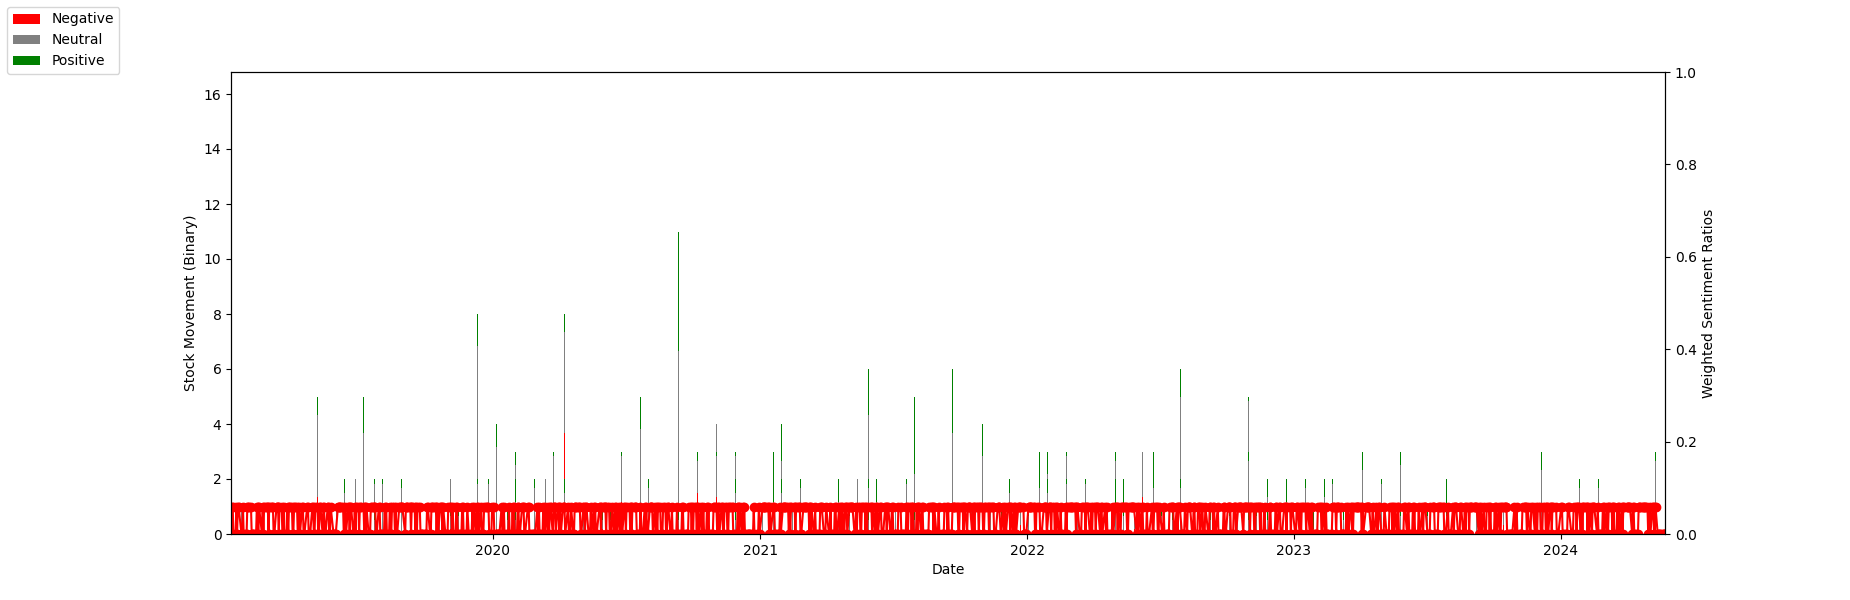

In [22]:
# Visualize Example Stock Price Movements (Up/Down) with Article Counts
%matplotlib ipympl
tz = pytz.timezone('America/New_York')

fig, ax1 = plt.subplots()
fig.set_size_inches(18.5, 6, forward=True)

tolerance = 2  # points

ret_binary = ret_df['CVX'].apply(lambda x: 1 if x > 0.0 else 0)

ax1.plot(ret_df.index, ret_binary, 'ro-', picker=tolerance)

# Calculate weighted values
dates = df_merged['Date']
weights = {
    "Negative": (df_merged['Neg_ratio_avg'] * df_merged['article_count']).tolist(),
    "Neutral": (df_merged['Neu_ratio_avg'] * df_merged['article_count']).tolist(),
    "Positive": (df_merged['Pos_ratio_avg'] * df_merged['article_count']).tolist()
}

colors = {
    "Negative": 'red',
    "Neutral": 'gray',
    "Positive": 'green'
}

ax2 = ax1.twinx()

width = 0.1
bottom = np.zeros(len(dates))

for sentiment, weight in weights.items():
    p = ax1.bar(dates, weight, width, label=sentiment, bottom=bottom, color=colors[sentiment])
    bottom += weight

ax1.set_xlim(left=ret_df.index.min(), right=ret_df.index.max())
ax2.set_xlim(left=ret_df.index.min(), right=ret_df.index.max())

# Add labels and legend
ax1.set_xlabel('Date')
ax1.set_ylabel('Stock Movement (Binary)')
ax2.set_ylabel('Weighted Sentiment Ratios')
fig.legend(loc='upper left')

plt.show()




def onclick(event):
    line = event.artist
    xdata, ydata = line.get_data()
    ind = event.ind
    datetime_obj  = xdata[ind][0].astype('datetime64[s]').astype(datetime)
    formatted_date = datetime_obj.strftime('%Y-%m-%d')
    print(formatted_date)
    #query = 'summarize the top news articles for chevron?'
    #top_results = 3
    #print(textwrap.fill(ask_vector_query(query, top_results, date=str(formatted_date), pinecone_index = "newsembedding3"), width=80))

#cid = fig.canvas.mpl_connect('button_press_event', onclick)
cid = fig.canvas.mpl_connect('pick_event', onclick)

In [23]:
# prep data for modeling
df_merged_drop = df_merged.drop(['Daily_Returns','Weekly_Returns'], axis=1)
df_dropna = df_merged_drop.dropna()

# Convert the 'Date' column to datetime
df_dropna['Date'] = pd.to_datetime(df_dropna['Date'])

# Define the split date
base_date = pd.to_datetime('2021-01-01')
split_date = pd.to_datetime('2023-01-01')

# Split the DataFrame
train_df = df_dropna[(df_dropna['Date'] < split_date) & (df_dropna['Date'] >= base_date)]
test_df = df_dropna[df_dropna['Date'] >= split_date]

# define input variables
X_train_df = train_df.drop(columns=['Date','Ticker','Daily_Returns (no NaN)'])
X_test_df = test_df.drop(columns=['Date','Ticker','Daily_Returns (no NaN)'])

# define target variable
y_train_df = train_df['Daily_Returns (no NaN)'].apply(lambda x: 1 if x > 0.0 else 0)
y_test_df = test_df['Daily_Returns (no NaN)'].apply(lambda x: 1 if x > 0.0 else 0)

# Split the dataset into training and test sets
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# If you need to separate features and labels
X_train = X_train_df
y_train = y_train_df

X_test = X_test_df
y_test = y_test_df

print(len(X_train), len(y_train), len(X_test), len(y_test))

2877 2877 1820 1820


<ipython-input-23-3281c7034027>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dropna['Date'] = pd.to_datetime(df_dropna['Date'])


Fitting 5 folds for each of 648 candidates, totalling 3240 fits


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


{'bootstrap': True, 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 300}
Accuracy: 0.6148351648351649
Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.72      0.65       913
           1       0.64      0.51      0.57       907

    accuracy                           0.61      1820
   macro avg       0.62      0.61      0.61      1820
weighted avg       0.62      0.61      0.61      1820

Index(['article_count', 'Finance', 'Production', 'Reserves_MA', 'Regulatory',
       'Green_Energy', 'OG_Price', 'Neu_ratio_avg', 'Pos_ratio_avg',
       'Neg_ratio_avg', 'Weekly_Returns (no NaN)'],
      dtype='object')
[0.03051684 0.03470215 0.032948   0.03357179 0.03267183 0.0323483
 0.03480166 0.05216804 0.04330976 0.04565903 0.6273026 ]


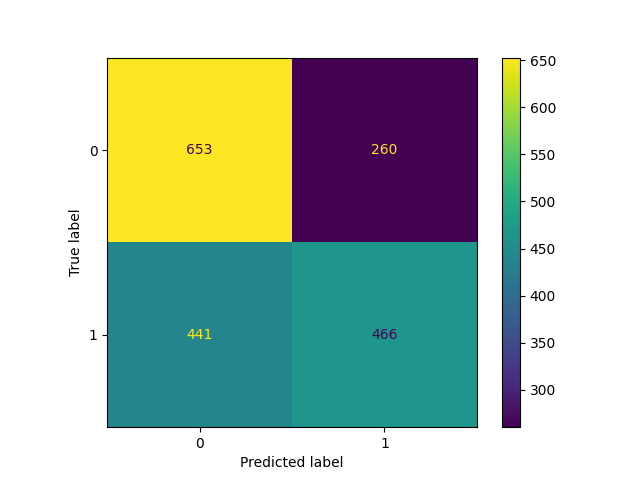

In [24]:
from math import log2
######## Train Random Forest Model ############

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2'],
    'bootstrap': [True, False]
}
#param_grid = {
#    'n_estimators': [300],
#    'max_depth': [None],
#    'min_samples_split': [5],
#    'min_samples_leaf': [1],
#    'max_features': ['log2'],
#    'bootstrap': [True]
#}

# Create a Random Forest classifier
rf_clf = RandomForestClassifier(random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=rf_clf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

# Train the classifier on the training set
grid_search.fit(X_train, y_train)

# Output the best parameters
print(grid_search.best_params_)

# Use the best estimator for predictions
best_model = grid_search.best_estimator_

# Make predictions on the test set
y_pred = best_model.predict(X_test)

# Calculate the accuracy of the classifier
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))
print(X_train_df.columns)
print(best_model.feature_importances_)
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(best_model, X_test, y_test)